In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


## EDA

In [2]:
df = pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [3]:
df = df.rename(columns={'event': 'churn'})
df = df.rename(columns={'coach': 'treatment'})

In [4]:
df.isnull().sum()

stag            0
churn           0
gender          0
age             0
industry        0
profession      0
traffic         0
treatment       0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1129 non-null   float64
 1   churn         1129 non-null   int64  
 2   gender        1129 non-null   object 
 3   age           1129 non-null   float64
 4   industry      1129 non-null   object 
 5   profession    1129 non-null   object 
 6   traffic       1129 non-null   object 
 7   treatment     1129 non-null   object 
 8   head_gender   1129 non-null   object 
 9   greywage      1129 non-null   object 
 10  way           1129 non-null   object 
 11  extraversion  1129 non-null   float64
 12  independ      1129 non-null   float64
 13  selfcontrol   1129 non-null   float64
 14  anxiety       1129 non-null   float64
 15  novator       1129 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 141.3+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
stag,1129.0,36.627526,34.096597,0.394251,11.728953,24.344969,51.318275,179.449692
churn,1129.0,0.505757,0.500188,0.000000,0.000000,1.000000,1.000000,1.000000
age,1129.0,31.066965,6.996147,18.000000,26.000000,30.000000,36.000000,58.000000
extraversion,1129.0,5.592383,1.851637,1.000000,4.600000,5.400000,7.000000,10.000000
independ,1129.0,5.478034,1.703312,1.000000,4.100000,5.500000,6.900000,10.000000
selfcontrol,1129.0,5.597254,1.980101,1.000000,4.100000,5.700000,7.200000,10.000000
anxiety,1129.0,5.665633,1.709176,1.700000,4.800000,5.600000,7.100000,10.000000
novator,1129.0,5.879628,1.904016,1.000000,4.400000,6.000000,7.500000,10.000000


In [7]:
print('Categorical columns: ')
for col in df.columns:
    if df[col].dtype == 'object':
        values = df[col].value_counts()
        values = dict(values)
        
        print(str(col))
        label = LabelEncoder()
        label = label.fit(df[col])
        df[col] = label.transform(df[col].astype(str))
        
        new_values = df[col].value_counts()
        new_values = dict(new_values)
        
        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
gender
{'f': 0, 'm': 1}
industry
{'Retail': 10, 'manufacture': 14, 'IT': 5, 'Banks': 2, 'etc': 13, 'Consult': 4, 'State': 11, 'Building': 3, 'PowerGeneration': 8, 'transport': 15, 'Telecom': 12, 'Mining': 6, 'Pharma': 7, 'Agriculture': 1, 'RealEstate': 9, ' HoReCa': 0}
profession
{'HR': 6, 'IT': 7, 'Sales': 11, 'etc': 13, 'Marketing': 9, 'BusinessDevelopment': 1, 'Consult': 3, 'Commercial': 2, 'manage': 14, 'Finanñe': 5, 'Engineer': 4, 'Teaching': 12, 'Accounting': 0, 'Law': 8, 'PR': 10}
traffic
{'youjs': 7, 'empjs': 2, 'rabrecNErab': 4, 'friends': 3, 'referal': 6, 'KA': 0, 'recNErab': 5, 'advert': 1}
treatment
{'no': 1, 'my head': 0, 'yes': 2}
head_gender
{'m': 1, 'f': 0}
greywage
{'white': 1, 'grey': 0}
way
{'bus': 0, 'car': 1, 'foot': 2}


In [8]:
df.head()

,stag,churn,gender,age,industry,profession,traffic,treatment,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,1,35.0,2,6,4,1,0,1,0,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,1,33.0,2,6,2,1,1,1,0,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,0,35.0,8,6,4,1,1,1,0,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,0,35.0,8,6,4,1,1,1,0,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,1,32.0,10,2,7,2,0,1,0,3.0,4.1,8.0,7.1,3.7


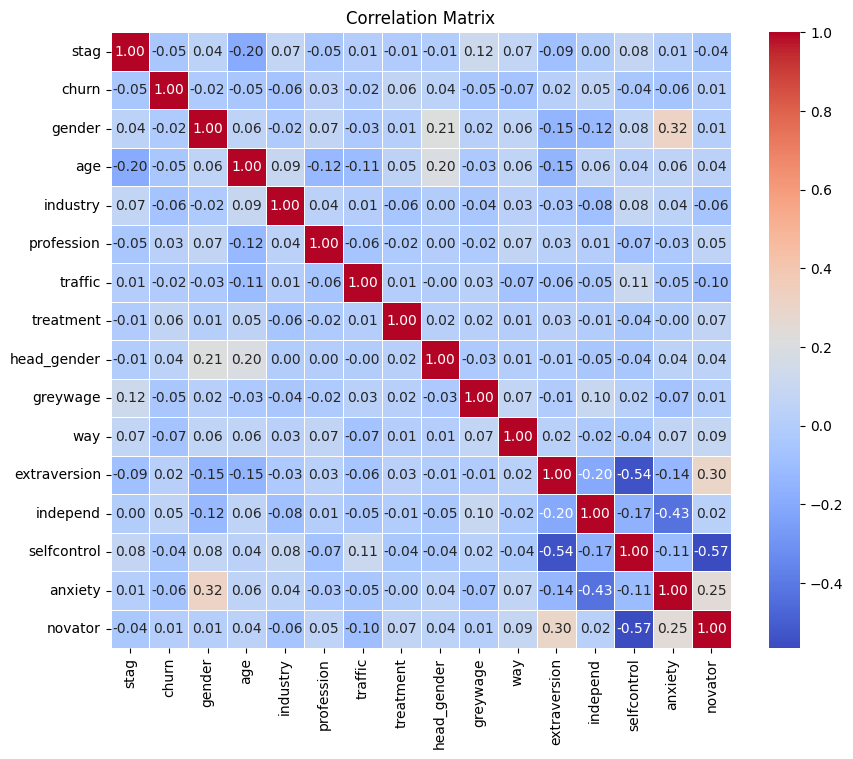

In [9]:
df_corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()

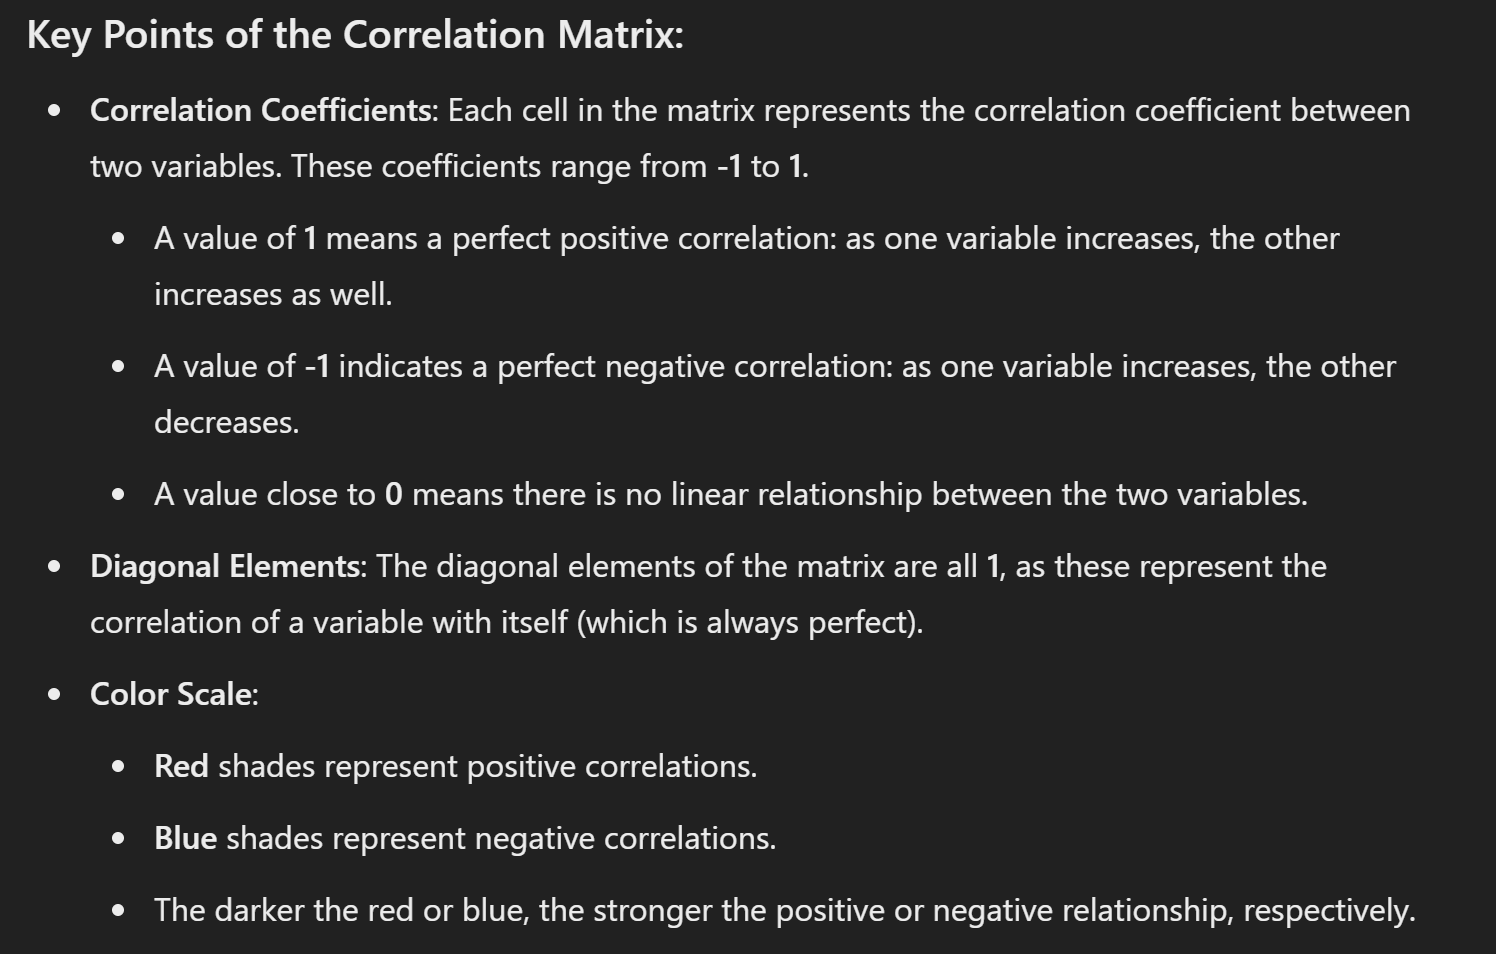

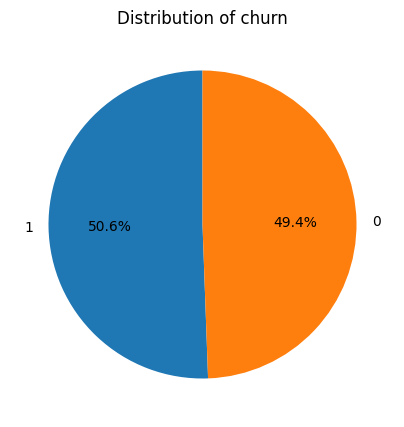

In [10]:
event_counts = df['churn'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of churn")
plt.show()


It seems that theres almost equal amount of employee that resigned and employee that did not data in this dataset

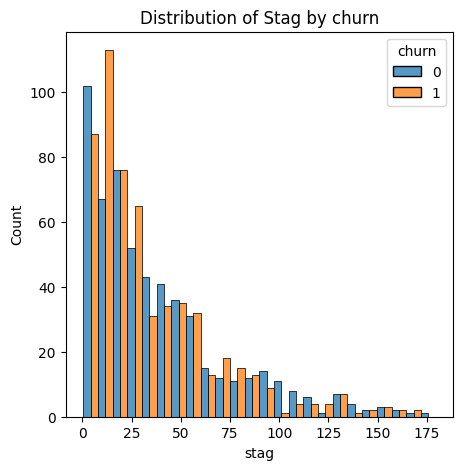

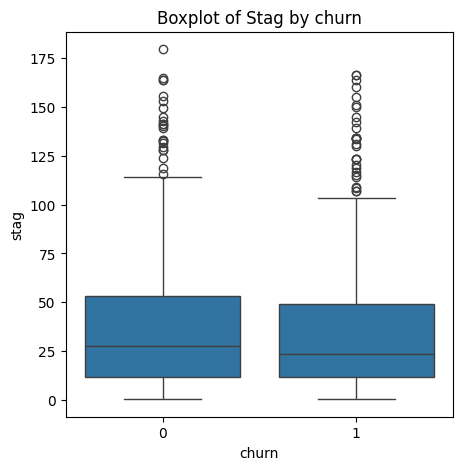

In [11]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x="stag", hue="churn", multiple="dodge", kde=False)
plt.title("Distribution of Stag by churn")
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(data=df, x="churn", y="stag")
plt.title("Boxplot of Stag by churn")
plt.show()

Looking at the graph above you can tell that experience (time) has a very weak correlation with employee quitting so we can can that experience (time) is not a major factor on employee resigning

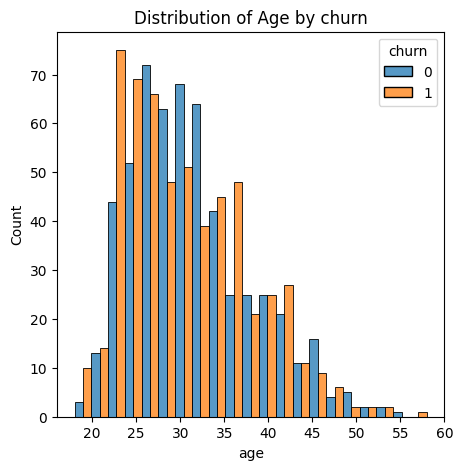

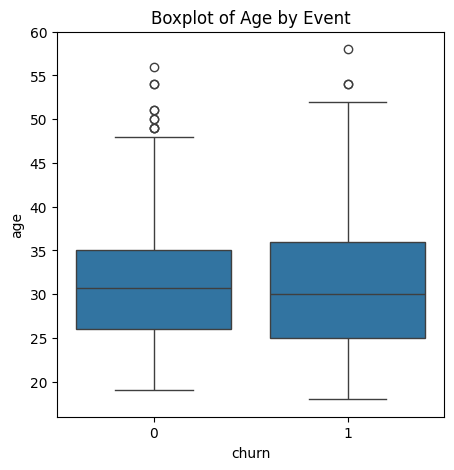

In [12]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x="age", hue="churn", multiple="dodge", kde=False)
plt.title("Distribution of Age by churn")
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(data=df, x="churn", y="age")
plt.title("Boxplot of Age by Event")
plt.show()

Expectedly, age is same as experience (time) as they both does not have strong correlations towards to employees resigning

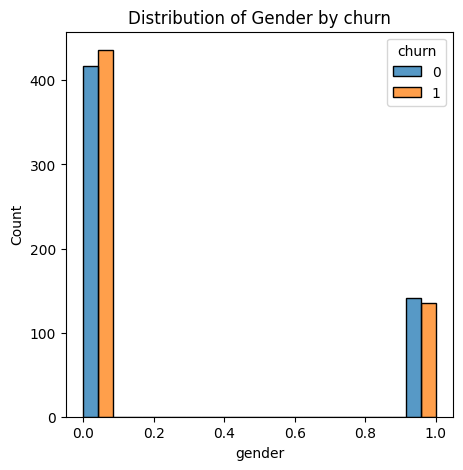

In [13]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x="gender", hue="churn", multiple="dodge", kde=False)
plt.title("Distribution of Gender by churn")
plt.show()

By analyzing the graphs above, all of them has a very weak to no correlations towards employees resigning

## Preprocessing

In [14]:
df = pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [15]:
df = df.rename(columns={'event': 'churn'})
df = df.rename(columns={'coach': 'treatment'})

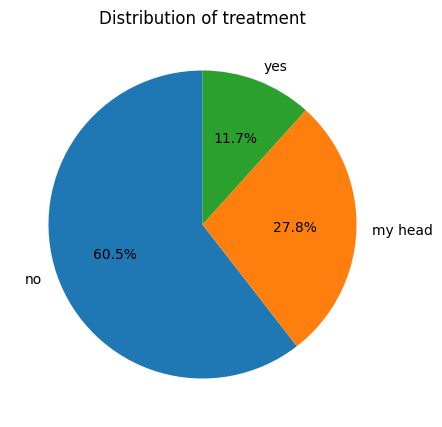

In [16]:
treatment_counts = df['treatment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(treatment_counts, labels=treatment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of treatment")
plt.show()

In [17]:
df.treatment = df.treatment.map({'yes': 0, 'no': 1, 'my head': 2})
df = df.loc[df.treatment <= 1].reset_index(drop=True)

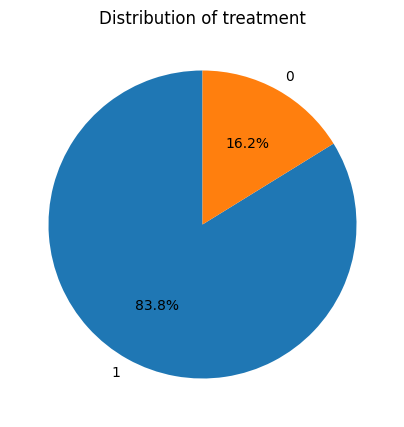

In [18]:
treatment_counts = df['treatment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(treatment_counts, labels=treatment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of treatment")
plt.show()

In [19]:
df = pd.get_dummies(df, drop_first=True)
df = df.astype(int)

In [20]:
column_to_move = df.pop('treatment') 
df['treatment'] = column_to_move 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   stag                            815 non-null    int64
 1   churn                           815 non-null    int64
 2   age                             815 non-null    int64
 3   extraversion                    815 non-null    int64
 4   independ                        815 non-null    int64
 5   selfcontrol                     815 non-null    int64
 6   anxiety                         815 non-null    int64
 7   novator                         815 non-null    int64
 8   gender_m                        815 non-null    int64
 9   industry_Agriculture            815 non-null    int64
 10  industry_Banks                  815 non-null    int64
 11  industry_Building               815 non-null    int64
 12  industry_Consult                815 non-null    int64
 13  indus

In [22]:
def correlation_treatment(df:pd.DataFrame):
    """Function to calculate the treatment's correlation
    """
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [23]:
print("\nTreatment correlation :", correlation_treatment(df).iloc[0,0])


Treatment correlation : -4.0


In [24]:
def declare_target_class(df:pd.DataFrame):
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

df = declare_target_class(df)

In [25]:
df.head()

,stag,churn,age,extraversion,independ,selfcontrol,anxiety,novator,gender_m,industry_Agriculture,...,traffic_rabrecNErab,traffic_recNErab,traffic_referal,traffic_youjs,head_gender_m,greywage_white,way_car,way_foot,treatment,target_class
0,7,1,35,6,4,5,7,8,1,0,...,1,0,0,0,0,1,0,0,1,2
1,22,1,33,6,4,5,7,8,1,0,...,0,0,0,0,1,1,0,0,1,2
2,15,1,35,6,6,2,4,8,0,0,...,1,0,0,0,1,1,0,0,1,2
3,15,1,35,5,7,4,2,6,0,0,...,1,0,0,0,1,1,0,0,1,2
4,8,1,32,3,4,8,7,3,1,0,...,0,0,0,1,0,1,0,0,0,0


In [26]:
X = df.drop(['churn','target_class'],axis=1)
y = df.churn
z = df.target_class 
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X,y,z,test_size=0.3,random_state=42,stratify=df['treatment'])

In [27]:
X_train.shape, X_test.shape, z_test.shape

((570, 49), (245, 49), (245,))

## Model 1

In [28]:
prediction_results = pd.DataFrame(X_test).copy()

model_1 = xgb.XGBClassifier()

model_1.fit(X_train.drop('treatment', axis=1), y_train)

prediction = model_1.predict(X_test.drop('treatment',axis=1))

probability = model_1.predict_proba(X_test.drop('treatment', axis=1)) 

prediction_results['prediction_churn'] = prediction

prediction_results['proba_churn'] = probability[:,1]

prediction_results['churn'] = y_test

prediction_results['target_class'] = z_test

In [29]:
classification_rep = classification_report(y_test, prediction)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.71      0.66      0.69       124
           1       0.68      0.73      0.70       121

    accuracy                           0.69       245
   macro avg       0.69      0.69      0.69       245
weighted avg       0.70      0.69      0.69       245



In [30]:
prediction_results.head()

,stag,age,extraversion,independ,selfcontrol,anxiety,novator,gender_m,industry_Agriculture,industry_Banks,...,traffic_youjs,head_gender_m,greywage_white,way_car,way_foot,treatment,prediction_churn,proba_churn,churn,target_class
514,116,38,7,9,2,4,9,1,0,0,...,0,1,1,1,0,0,1,0.753638,1,0
475,45,34,7,1,9,5,6,0,0,0,...,1,0,1,0,0,1,1,0.621015,1,2
212,68,24,7,4,2,7,7,0,0,0,...,0,0,1,0,1,1,1,0.987906,1,2
53,4,26,3,4,5,7,2,0,0,0,...,0,0,1,1,0,1,1,0.862747,1,2
721,14,30,5,3,9,6,3,1,0,0,...,0,1,0,1,0,1,0,0.133596,0,3


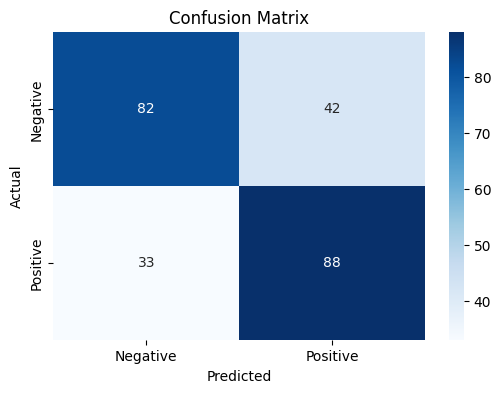

In [31]:
cm = confusion_matrix(y_test, prediction)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

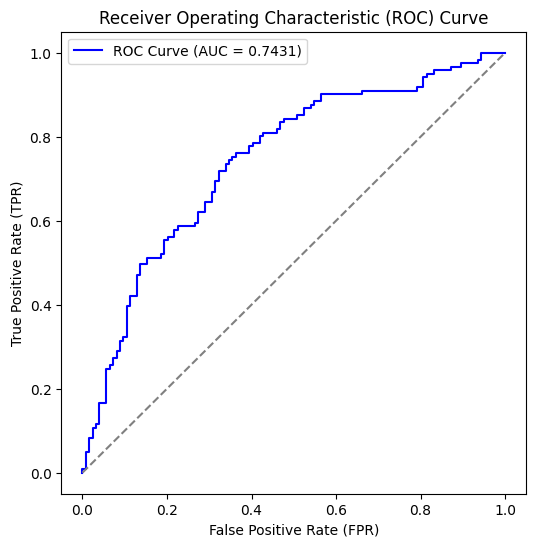

In [32]:
y_pred_proba = model_1.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

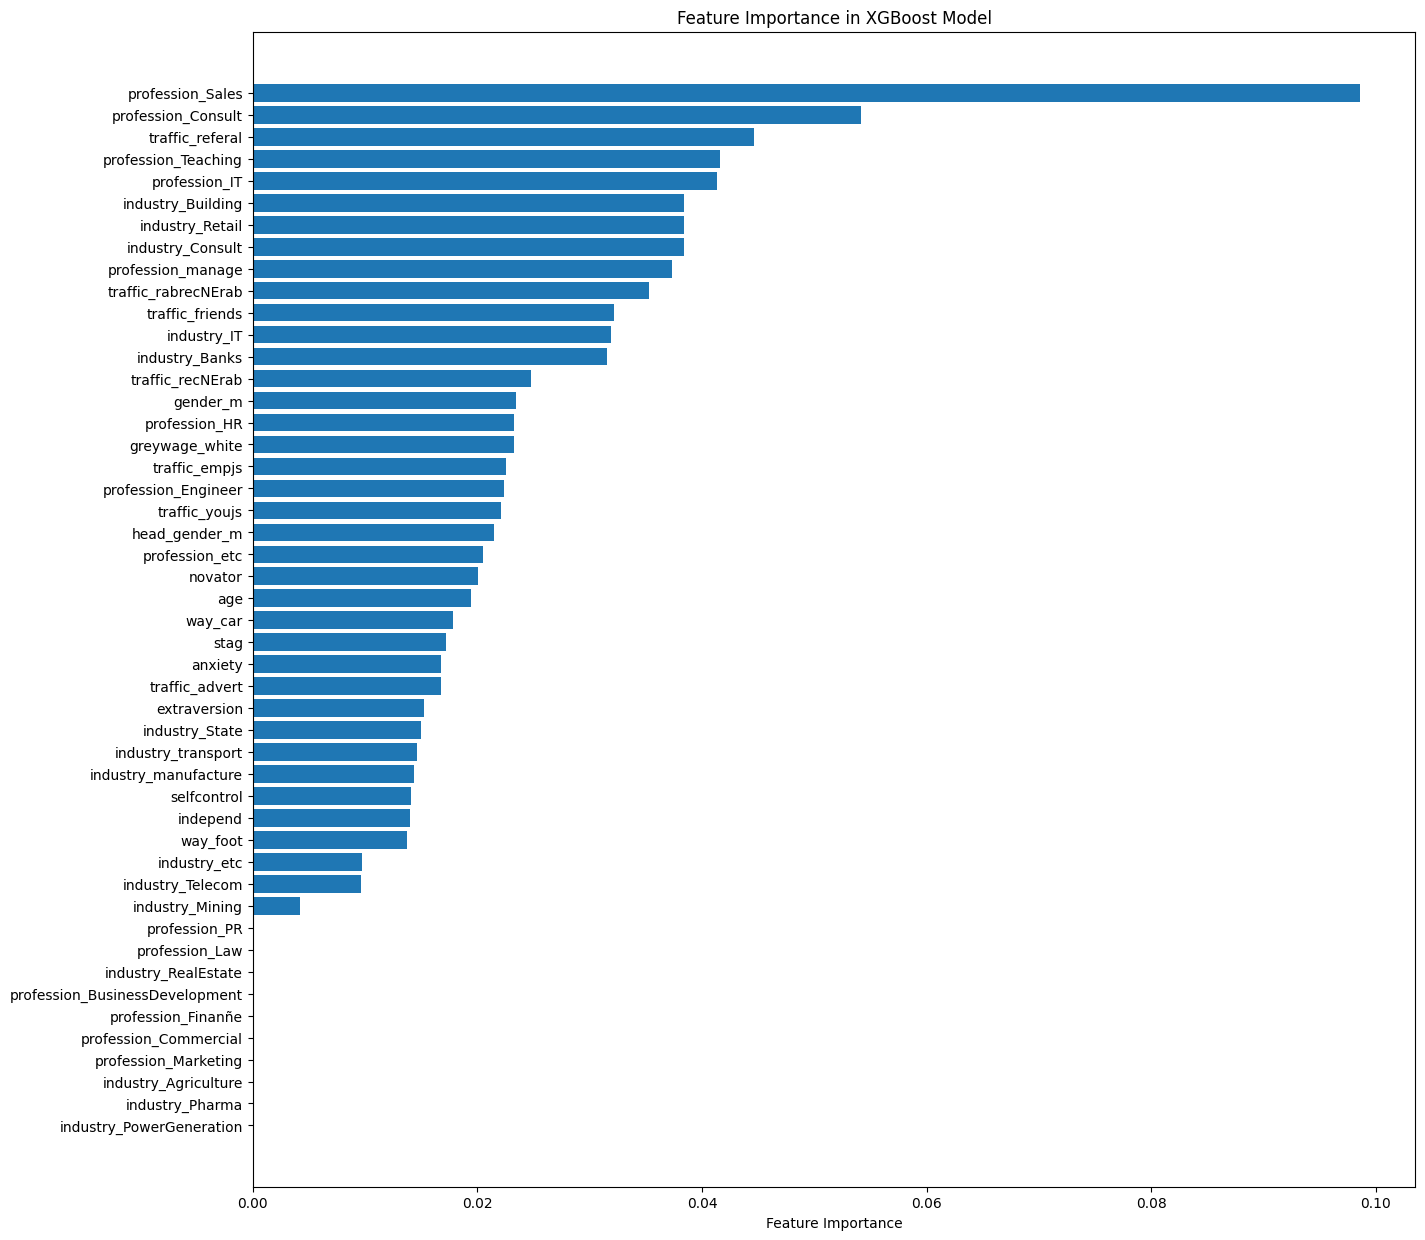

In [33]:
importance = model_1.feature_importances_
features = X.columns.drop('treatment')

sorted_idx = importance.argsort()

plt.figure(figsize=(15, 15))
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in XGBoost Model")
plt.show()

## Model 2

In [34]:
model_2 = xgb.XGBClassifier()

model_2.fit(X_train.drop('treatment', axis=1), z_train)

prediction = model_2.predict(X_test.drop('treatment', axis=1))

probability = model_2.predict_proba(X_test.drop('treatment', axis=1))

prediction_results['prediction_target_class'] = prediction

prediction_results['proba_CN'] = probability[:,0]

prediction_results['proba_CR'] = probability[:,1] 

prediction_results['proba_TN'] = probability[:,2] 

prediction_results['proba_TR'] = probability[:,3]

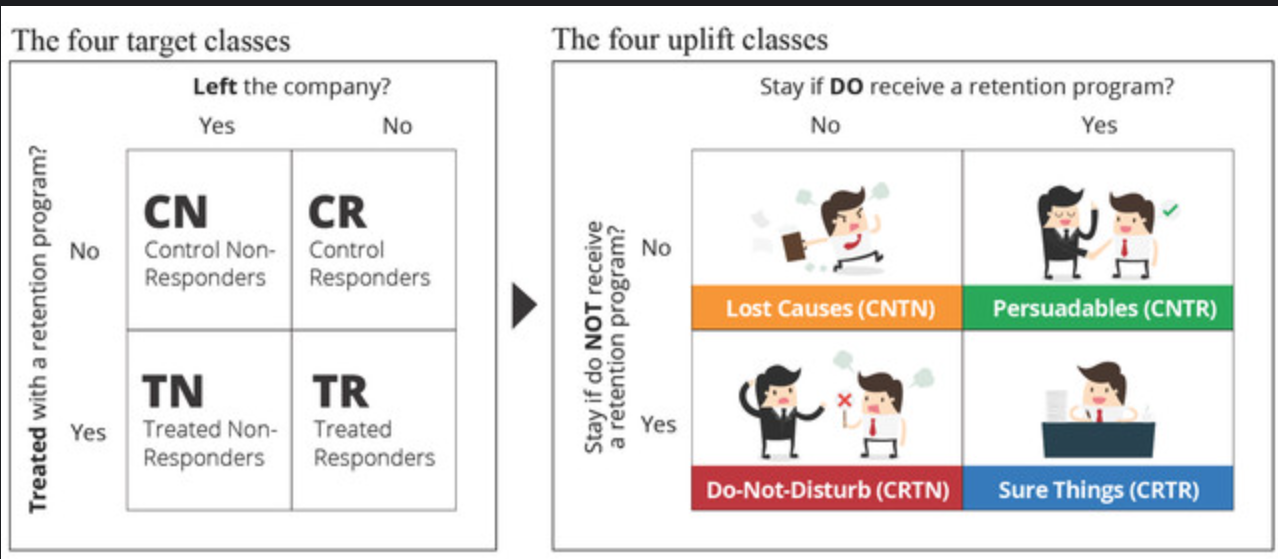

In [35]:
prediction_results.head()

,stag,age,extraversion,independ,selfcontrol,anxiety,novator,gender_m,industry_Agriculture,industry_Banks,...,treatment,prediction_churn,proba_churn,churn,target_class,prediction_target_class,proba_CN,proba_CR,proba_TN,proba_TR
514,116,38,7,9,2,4,9,1,0,0,...,0,1,0.753638,1,0,2,0.007182,0.009622,0.577417,0.405779
475,45,34,7,1,9,5,6,0,0,0,...,1,1,0.621015,1,2,2,0.000192,0.005755,0.561228,0.432825
212,68,24,7,4,2,7,7,0,0,0,...,1,1,0.987906,1,2,0,0.625234,0.086173,0.277206,0.011387
53,4,26,3,4,5,7,2,0,0,0,...,1,1,0.862747,1,2,2,0.020785,0.012952,0.734505,0.231758
721,14,30,5,3,9,6,3,1,0,0,...,1,0,0.133596,0,3,3,0.003737,0.000933,0.075085,0.920245


In [36]:
classification_rep = classification_report(z_test, prediction)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.42      0.22      0.29        23
           1       0.56      0.29      0.38        17
           2       0.53      0.63      0.58        98
           3       0.58      0.58      0.58       107

    accuracy                           0.55       245
   macro avg       0.52      0.43      0.46       245
weighted avg       0.54      0.55      0.54       245



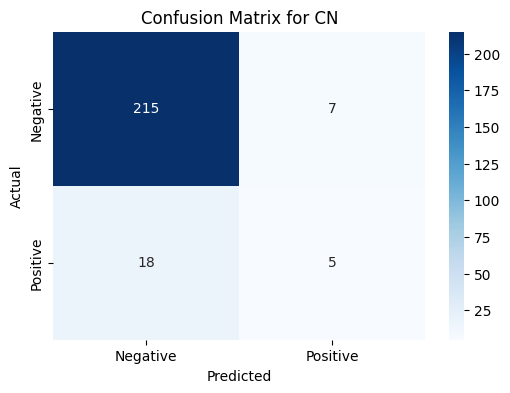

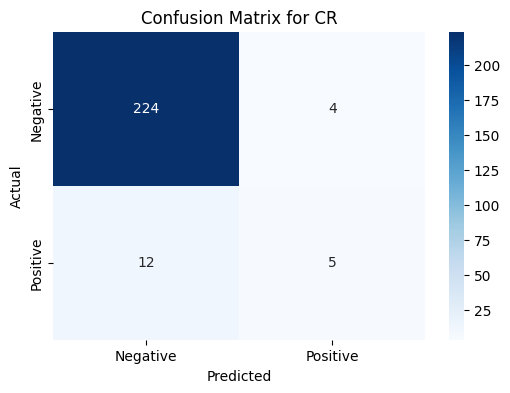

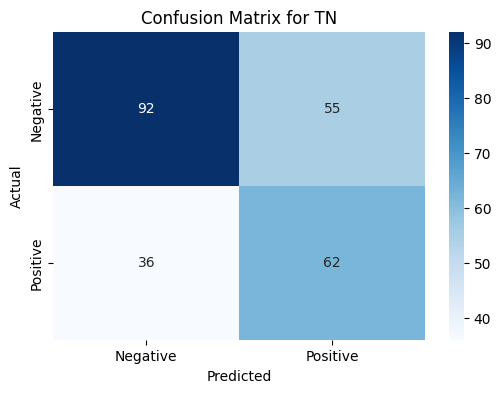

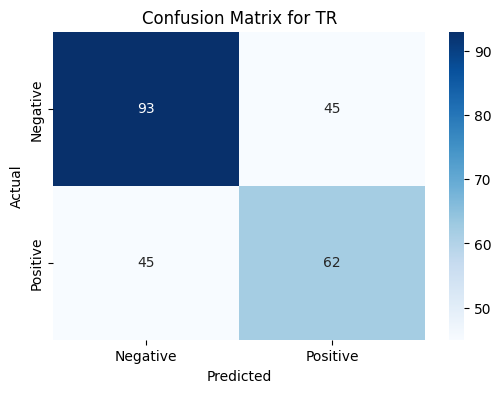

In [37]:
class_labels = ['CN', 'CR', 'TN', 'TR']

confusion_matrices = {}

for i, label in enumerate(class_labels):
    cm = confusion_matrix(z_test == i, prediction == i)
    confusion_matrices[label] = cm


def plot_confusion_matrix(cm, class_name):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

for class_name, cm in confusion_matrices.items():
    plot_confusion_matrix(cm, class_name)



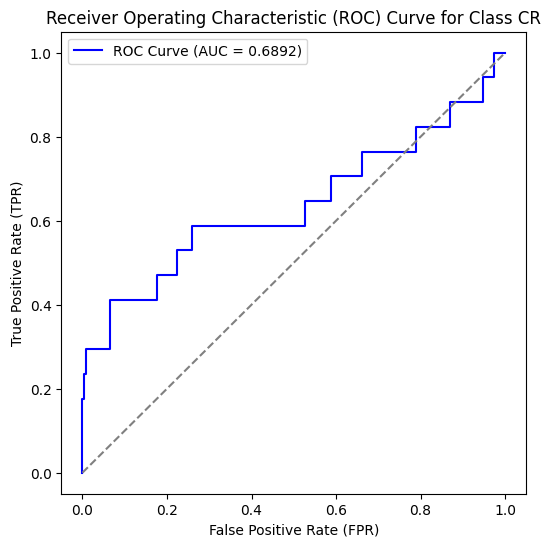

In [38]:
roc_auc = roc_auc_score(z_test, probability, multi_class='ovr')

fpr, tpr, thresholds = roc_curve(z_test, probability[:, 1], pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class CR')
plt.legend()
plt.show()

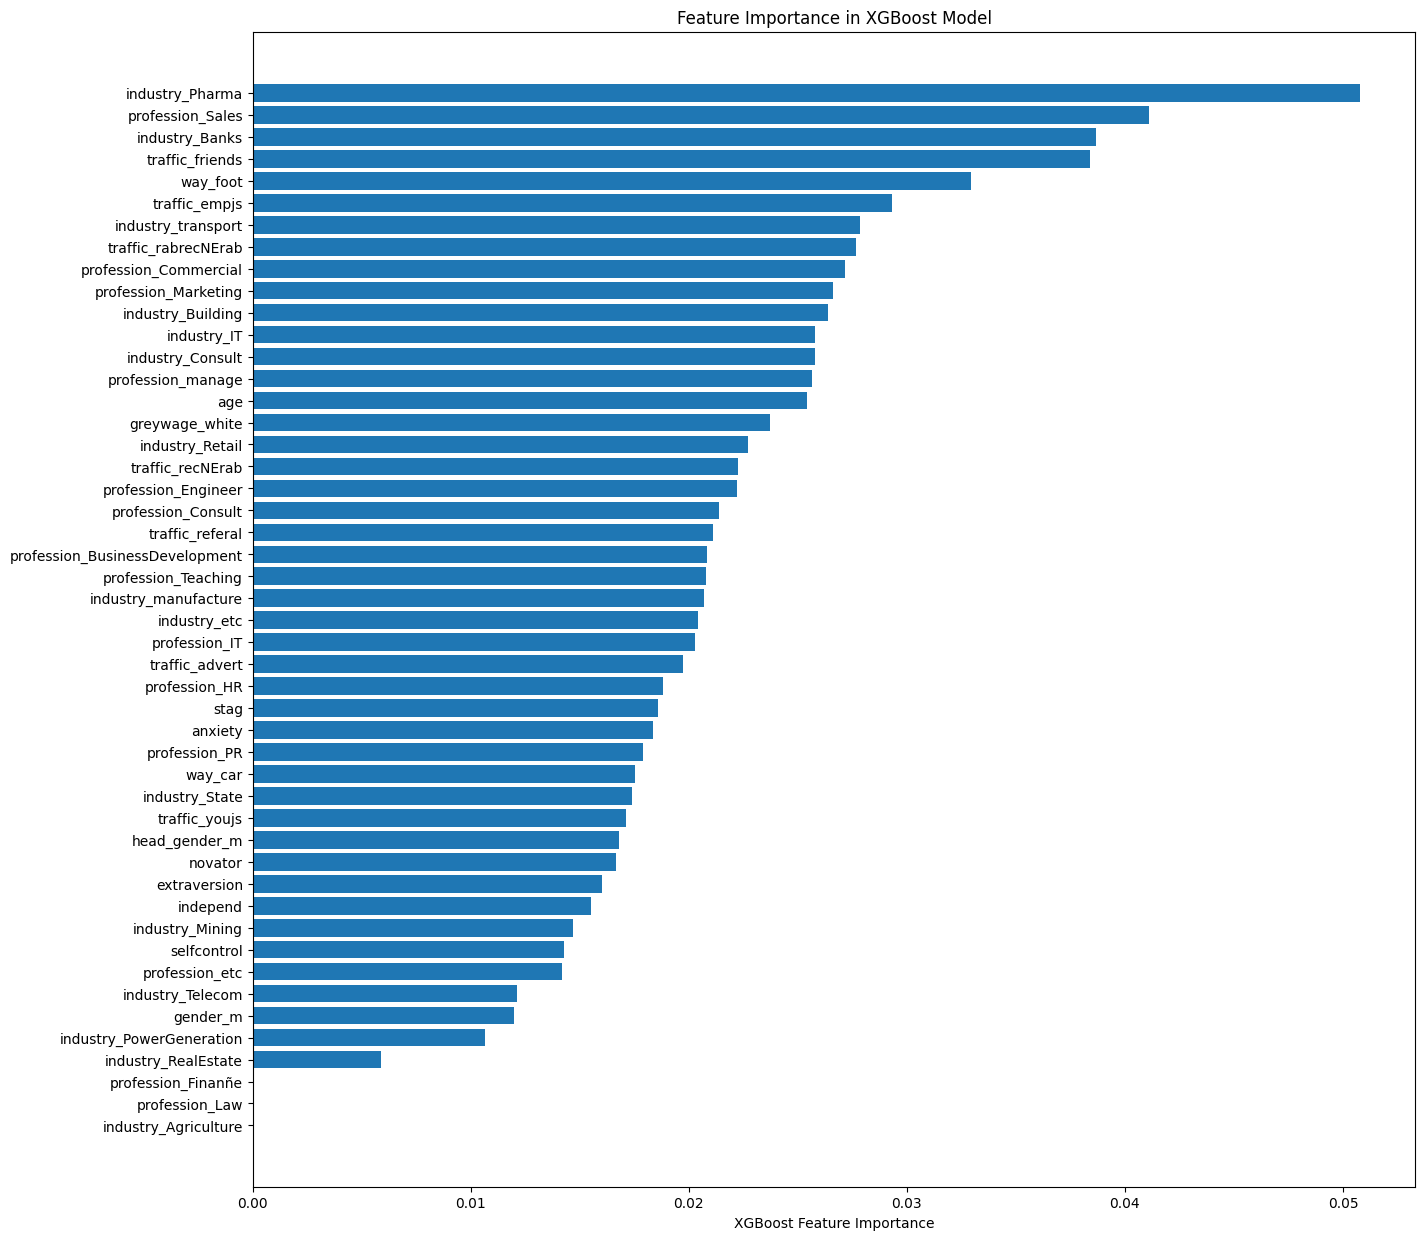

In [39]:
importance = model_2.feature_importances_
features = X.columns.drop('treatment')

sorted_idx = importance.argsort()

plt.figure(figsize=(15, 15))
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance in XGBoost Model")
plt.show()

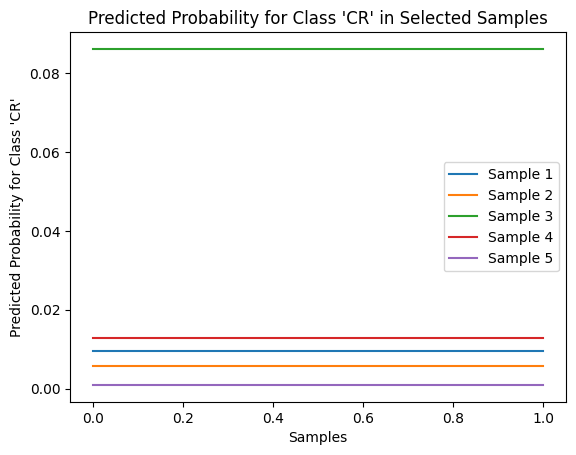

Sample 1: Estimated probability for class CR = 0.0096
Sample 2: Estimated probability for class CR = 0.0058
Sample 3: Estimated probability for class CR = 0.0862
Sample 4: Estimated probability for class CR = 0.0130
Sample 5: Estimated probability for class CR = 0.0009


In [48]:
class_CR_index = 1

probabilities_new = model_2.predict_proba(X_test.drop('treatment', axis=1)[:5])

for i in range(5):
    surv_prob = probabilities_new[i, class_CR_index]
    plt.step([0, 1], [surv_prob, surv_prob], where="mid", label=f"Sample {i+1}")

plt.title("Predicted Probability for Class 'CR' in Selected Samples")
plt.xlabel("Samples")
plt.ylabel("Predicted Probability for Class 'CR'")
plt.legend()
plt.show()

for i in range(5):
    print(f"Sample {i+1}: Estimated probability for class CR = {probabilities_new[i, class_CR_index]:.4f}")
